In [1]:
import numpy as np
import pandas as pd
import os

In [2]:
import torch
import torchvision 
import torchvision
from torchvision import datasets, models
from torchvision.transforms import functional as FT
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset

In [5]:
import copy
import math
from PIL import Image
import cv2
import matplotlib.pyplot as plt
import albumentations as A

C:\Users\Shashwat\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated and will be removed in a future release
  "class": algorithms.Blowfish,


In [7]:
from collections import defaultdict, deque
import datetime
import time
from tqdm import tqdm 
from torchvision.utils import draw_bounding_boxes

In [9]:
print(torch.__version__)
print(torchvision.__version__)

2.3.1
0.18.1


In [11]:
from pycocotools.coco import COCO

In [13]:
from albumentations.pytorch import ToTensorV2

In [15]:
def get_transforms(train=False):
    if train:
        transform = A.Compose([
            A.Resize(600,600),
            A.HorizontalFlip(p=0.3),
            A.VerticalFlip(p=0.3),
            A.RandomBrightnessContrast(p=0.1),
            A.ColorJitter(p=0.1),
            ToTensorV2()
        ], bbox_params=A.BboxParams(format='coco'))
    else:
        transform = A.Compose([
            A.Resize(600,600),
            ToTensorV2()
        ], bbox_params=A.BboxParams(format='coco'))
    return transform

In [17]:
class CocoDataset(datasets.VisionDataset):
    def __init__(self, root, image_folder, annotation_file, split='train', transform=None, target_transform=None, transforms=None):
        # The 3 transform parameters are required for datasets.VisionDataset
        super().__init__(root, transforms, transform, target_transform)
        self.root = root
        self.image_folder = image_folder
        self.split = split  # train, valid, test
        self.coco = COCO(os.path.join(root, annotation_file))  # Annotations stored here
        self.ids = list(sorted(self.coco.imgs.keys()))
        self.ids = [id for id in self.ids if (len(self._load_target(id)) > 0)]

    def _load_image(self, id: int):
        path = self.coco.loadImgs(id)[0]['file_name']
        image_path = os.path.join(self.root, self.image_folder, path)
        image = cv2.imread(image_path)
        
        if image is None:
            raise FileNotFoundError(f"Image not found at {image_path}")
        
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        return image

    def _load_target(self, id):
        return self.coco.loadAnns(self.coco.getAnnIds(id))

    def __getitem__(self, index):
        id = self.ids[index]
        image = self._load_image(id)
        target = self._load_target(id)
        target = copy.deepcopy(self._load_target(id))

        boxes = [t['bbox'] + [t['category_id']] for t in target]  # Required annotation format for albumentations
        if self.transforms is not None:
            transformed = self.transforms(image=image, bboxes=boxes)

        image = transformed['image']
        boxes = transformed['bboxes']

        new_boxes = []  # Convert from xywh to xyxy
        for box in boxes:
            xmin = box[0]
            xmax = xmin + box[2]
            ymin = box[1]
            ymax = ymin + box[3]
            new_boxes.append([xmin, ymin, xmax, ymax])

        boxes = torch.tensor(new_boxes, dtype=torch.float32)

        targ = {}  # Here is our transformed target
        targ['boxes'] = boxes
        targ['labels'] = torch.tensor([t['category_id'] for t in target], dtype=torch.int64)
        targ['image_id'] = torch.tensor([t['image_id'] for t in target])
        targ['area'] = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])  # We have a different area
        targ['iscrowd'] = torch.tensor([t['iscrowd'] for t in target], dtype=torch.int64)
        return image.div(255), targ  # Scale images

    def __len__(self):
        return len(self.ids)

In [19]:
train_dataset_path = "Dataset/train2017/train2017"

In [24]:
coco = COCO(os.path.join("Dataset/annotations_trainval2017/annotations/instances_train2017.json"))

loading annotations into memory...
Done (t=21.32s)
creating index...
index created!


In [28]:
categories = coco.cats
n_classes = len(categories.keys())

In [30]:
categories

{1: {'supercategory': 'person', 'id': 1, 'name': 'person'},
 2: {'supercategory': 'vehicle', 'id': 2, 'name': 'bicycle'},
 3: {'supercategory': 'vehicle', 'id': 3, 'name': 'car'},
 4: {'supercategory': 'vehicle', 'id': 4, 'name': 'motorcycle'},
 5: {'supercategory': 'vehicle', 'id': 5, 'name': 'airplane'},
 6: {'supercategory': 'vehicle', 'id': 6, 'name': 'bus'},
 7: {'supercategory': 'vehicle', 'id': 7, 'name': 'train'},
 8: {'supercategory': 'vehicle', 'id': 8, 'name': 'truck'},
 9: {'supercategory': 'vehicle', 'id': 9, 'name': 'boat'},
 10: {'supercategory': 'outdoor', 'id': 10, 'name': 'traffic light'},
 11: {'supercategory': 'outdoor', 'id': 11, 'name': 'fire hydrant'},
 13: {'supercategory': 'outdoor', 'id': 13, 'name': 'stop sign'},
 14: {'supercategory': 'outdoor', 'id': 14, 'name': 'parking meter'},
 15: {'supercategory': 'outdoor', 'id': 15, 'name': 'bench'},
 16: {'supercategory': 'animal', 'id': 16, 'name': 'bird'},
 17: {'supercategory': 'animal', 'id': 17, 'name': 'cat'},

In [32]:
classes = [i[1]['name'] for i in categories.items()]
classes

['person',
 'bicycle',
 'car',
 'motorcycle',
 'airplane',
 'bus',
 'train',
 'truck',
 'boat',
 'traffic light',
 'fire hydrant',
 'stop sign',
 'parking meter',
 'bench',
 'bird',
 'cat',
 'dog',
 'horse',
 'sheep',
 'cow',
 'elephant',
 'bear',
 'zebra',
 'giraffe',
 'backpack',
 'umbrella',
 'handbag',
 'tie',
 'suitcase',
 'frisbee',
 'skis',
 'snowboard',
 'sports ball',
 'kite',
 'baseball bat',
 'baseball glove',
 'skateboard',
 'surfboard',
 'tennis racket',
 'bottle',
 'wine glass',
 'cup',
 'fork',
 'knife',
 'spoon',
 'bowl',
 'banana',
 'apple',
 'sandwich',
 'orange',
 'broccoli',
 'carrot',
 'hot dog',
 'pizza',
 'donut',
 'cake',
 'chair',
 'couch',
 'potted plant',
 'bed',
 'dining table',
 'toilet',
 'tv',
 'laptop',
 'mouse',
 'remote',
 'keyboard',
 'cell phone',
 'microwave',
 'oven',
 'toaster',
 'sink',
 'refrigerator',
 'book',
 'clock',
 'vase',
 'scissors',
 'teddy bear',
 'hair drier',
 'toothbrush']

In [34]:
annotation_file = 'annotations_trainval2017/annotations/instances_train2017.json'
root='Dataset/'
image_folder = 'train2017/train2017'

In [36]:
train_dataset = CocoDataset(root=root, image_folder=image_folder, annotation_file=annotation_file, transforms=get_transforms(train=True))

loading annotations into memory...
Done (t=18.97s)
creating index...
index created!


In [38]:
sample = train_dataset[12]
img_int = torch.tensor(sample[0] * 255, dtype=torch.uint8)

C:\Users\Shashwat\AppData\Local\Temp\ipykernel_17188\3065028406.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img_int = torch.tensor(sample[0] * 255, dtype=torch.uint8)


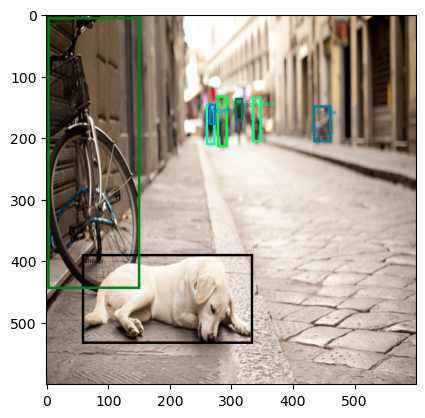

In [40]:
plt.imshow(draw_bounding_boxes(
    img_int, sample[1]['boxes'], [classes[i] for i in sample[1]['labels']], width=4
).permute(1,2,0))

In [42]:
len(train_dataset)

117266

In [52]:
model = models.detection.fasterrcnn_mobilenet_v3_large_fpn(pretrained=False)
in_features = model.roi_heads.box_predictor.cls_score.in_features 
model.roi_heads.box_predictor = models.detection.faster_rcnn.FastRCNNPredictor(in_features, n_classes)

C:\Users\Shashwat\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Shashwat\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [54]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [56]:
train_loader = DataLoader(train_dataset, batch_size = 128, shuffle=True, num_workers=4, collate_fn=collate_fn)

In [58]:
device = torch.device("cuda")

In [60]:
model = model.to(device)

In [62]:
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.01, momentum=0.9, nesterov=True, weight_decay =1e-4)

In [64]:
import sys

In [66]:
def train_one_epoch(model, optimizer, loader, device, epoch):
    model.to(device)
    model.train()
    
#     lr_scheduler = None
#     if epoch == 0:
#         warmup_factor = 1.0 / 1000 # do lr warmup
#         warmup_iters = min(1000, len(loader) - 1)
        
#         lr_scheduler = optim.lr_scheduler.LinearLR(optimizer, start_factor = warmup_factor, total_iters=warmup_iters)
    
    all_losses = []
    all_losses_dict = []
    
    for images, targets in tqdm(loader):
        images = list(image.to(device) for image in images)
        targets = [{k: torch.tensor(v).to(device) for k, v in t.items()} for t in targets]
        
        loss_dict = model(images, targets) # the model computes the loss automatically if we pass in targets
        losses = sum(loss for loss in loss_dict.values())
        loss_dict_append = {k: v.item() for k, v in loss_dict.items()}
        loss_value = losses.item()
        
        all_losses.append(loss_value)
        all_losses_dict.append(loss_dict_append)
        
        if not math.isfinite(loss_value):
            print(f"Loss is {loss_value}, stopping trainig") # train if loss becomes infinity
            print(loss_dict)
            sys.exit(1)
        
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        
#         if lr_scheduler is not None:
#             lr_scheduler.step() # 
        
    all_losses_dict = pd.DataFrame(all_losses_dict) # for printing
    print("Epoch {}, lr: {:.6f}, loss: {:.6f}, loss_classifier: {:.6f}, loss_box: {:.6f}, loss_rpn_box: {:.6f}, loss_object: {:.6f}".format(
        epoch, optimizer.param_groups[0]['lr'], np.mean(all_losses),
        all_losses_dict['loss_classifier'].mean(),
        all_losses_dict['loss_box_reg'].mean(),
        all_losses_dict['loss_rpn_box_reg'].mean(),
        all_losses_dict['loss_objectness'].mean()
    ))

In [75]:
def train_nn(model, train_loader, test_loader, criterion, optimizer, n_epochs):
    device = set_device()
    best_acc = 0
    for epoch in range(n_epochs):
        print(f"Epoch number %d" % (epoch + 1))
        model.train()
        running_loss = 0
        running_correct = 0
        total = 0

        for data in train_loader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            total += labels.size(0)

            optimizer.zero_grad()

            outputs = model(images)

            _, predicted = torch.max(outputs.data, 1)

            loss = criterion(outputs, labels)

            loss.backward()

            optimizer.step()

            running_loss += loss.item()
            running_correct += (labels==predicted).sum().item()
        epoch_loss = running_loss/len(train_loader)
        epoch_acc = 100.00 * running_correct/total
        print(f"    - Training dataset. Got %d out of %d images correctly (%.3f%%). Epoch loss: %.3f"
              % (running_correct, total, epoch_acc, epoch_loss,))
        
        val_dataset_acc = evalate_model_on_test_set(model, test_loader)
        if (test_dataset_acc > best_acc):
            best_acc = test_dataset_acc
            save_checkpoint(model, epoch, optimizer, best_acc)
    print("Finished")
    return model

In [77]:
def evalate_model_on_test_set(model, test_loader):
    model.eval()
    predicted_correctly_on_epoch = 0
    total = 0
    device = set_device()

    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            total += labels.size(0)

            outputs = model(images)

            _, predicted = torch.max(outputs.data, 1)

            predicted_correctly_on_epoch += (predicted == labels).sum().item()
    epoch_acc = 100.0 * predicted_correctly_on_epoch / total
    print(f"    - Testing dataset. Got %d out of %d images correctly (%.3f%%)"
          % (predicted_correctly_on_epoch, total, epoch_acc))

In [79]:
def save_checkpoint(model, epoch, optimizer, best_acc):
    state = {
        'epoch': epoch+1,
        'model' : model.state_dict(),
        'best_accuracy': best_acc,
        'optimizer' : optimizer.state_dict,
        'comments' : 'very cool model!',
    }
    torch.save(state, 'model_best_checkpoint.pth.tar')

In [81]:
def set_device():
    if torch.cuda.is_available():
        dev = "cuda:0"
    else:
        dev = "cpu"
    return torch.device(dev)

In [83]:
annotation_file = 'annotations_trainval2017/annotations/instances_val2017.json'
root='Dataset/'
image_folder = 'val2017/val2017'

In [85]:
validation_dataset = CocoDataset(root=root, image_folder=image_folder, annotation_file=annotation_file, transforms=get_transforms(train=True))

loading annotations into memory...
Done (t=0.61s)
creating index...
index created!


In [89]:
val_loader = DataLoader(train_dataset, batch_size = 128, shuffle=True, num_workers=4, collate_fn=collate_fn)

In [ ]:
train_nn(model, train_loader, val_loader, criterion, optimizer, 10)

Epoch number 1


In [ ]:
model.eval()
torch.cuda.empty_cache()

In [ ]:
num_epochs=10

for epoch in range(num_epochs):
    train_one_epoch(model, optimizer, train_loader, device, epoch)

  0%|                                                                                          | 0/917 [00:00<?, ?it/s]